<a href="https://colab.research.google.com/github/ggsmith842/pytorch-tutorials/blob/main/Unidirectional_SL_RNN_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -Uq datasets huggingface_hub fsspec

In [ ]:
import os
import time
import nltk
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
nltk.download('stopwords')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# load imdb dataset from huggingface
ds = load_dataset("stanfordnlp/imdb")

In [ ]:
merged_dataset = concatenate_datasets([ds['train'], ds['test']])
split_dataset = merged_dataset.train_test_split(test_size=0.25, shuffle=True, seed=42)

train = split_dataset['train']
test = split_dataset['test']

In [ ]:
# pre-process text reviews
def build_vocab(text):
  # apply lowercase to all text
  stop_words = set(stopwords.words('english'))
  lowercase_text = [review.lower() for review in text]
  # remove punctuation
  nopunc_text = [''.join([letter for letter in review if letter not in punctuation]) for review in lowercase_text]
  cleaned_text = [' '.join(word for word in review.split() if word not in stop_words) for review in nopunc_text]
  reviews_blob =' '.join(cleaned_text)

  word_count = Counter(reviews_blob.split()).most_common()
  print(f'Top 10 words:\n{word_count[:10]}')

  # create word to integer token dictionary
  # to encode text as numbers
  vocab = {word:idx+1 for idx, (word, count) in enumerate(word_count)}

  return (cleaned_text, vocab)


In [ ]:
def tokenize(cleaned_text, vocab):
  review_tokens = []
  for review in cleaned_text:
    word_tokens = [vocab[word] for word in review.split()]
    review_tokens.append(word_tokens)
  return review_tokens

In [ ]:
# pad sequence
def pad_sequence(review_tokens, seq_len):
  padded_reviews = np.zeros((len(review_tokens), seq_len), dtype=int)

  for idx, review in enumerate(review_tokens):
    review_len = len(review)
    if review_len <= seq_len:
      zeros = list(np.zeros(
          seq_len - review_len
      ))
      new_seq = zeros + review
    elif review_len > seq_len:
      new_seq = review[0:seq_len]

    padded_reviews[idx,:] = np.array(new_seq)
  return padded_reviews

In [ ]:
train_clean_text, train_vocab = build_vocab(train['text'])
train_tokens = tokenize(train_clean_text, train_vocab)

Top 10 words:
[('br', 85431), ('movie', 62475), ('film', 55885), ('one', 38167), ('like', 29155), ('good', 21418), ('even', 18351), ('would', 17996), ('time', 17440), ('really', 17239)]


In [ ]:
print(train_clean_text[0])
print(train_tokens[0])

movie one boring horror movies seen long time seen lot personally liked piercing take original pretty unwatchable could stand dee snider actor singer seemed trying everything said make memorable quote werent get movies free still didnt think worth time get
[2, 4, 239, 98, 25, 32, 102, 9, 32, 75, 1146, 304, 11154, 94, 112, 86, 4002, 26, 758, 4751, 13817, 191, 1817, 337, 154, 158, 198, 24, 749, 3092, 1020, 15, 25, 836, 46, 60, 29, 166, 9, 15]


(array([2.8032e+04, 7.1410e+03, 1.7150e+03, 5.7900e+02, 2.3000e+01,
        4.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([   4. ,  148.5,  293. ,  437.5,  582. ,  726.5,  871. , 1015.5,
        1160. , 1304.5, 1449. ]),
 <BarContainer object of 10 artists>)

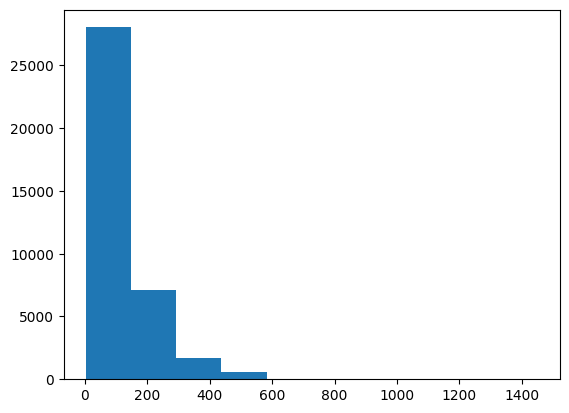

In [ ]:
padded_reviews = pad_sequence(train_tokens, seq_len=512)
plt.hist([len(review) for review in train_tokens])

Top 10 words:
[('br', 28363), ('movie', 21035), ('film', 18568), ('one', 12857), ('like', 9834), ('good', 7151), ('even', 6221), ('would', 6028), ('time', 5817), ('really', 5709)]


(array([8.133e+03, 2.997e+03, 8.960e+02, 3.270e+02, 1.350e+02, 8.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([   3. ,  118.2,  233.4,  348.6,  463.8,  579. ,  694.2,  809.4,
         924.6, 1039.8, 1155. ]),
 <BarContainer object of 10 artists>)

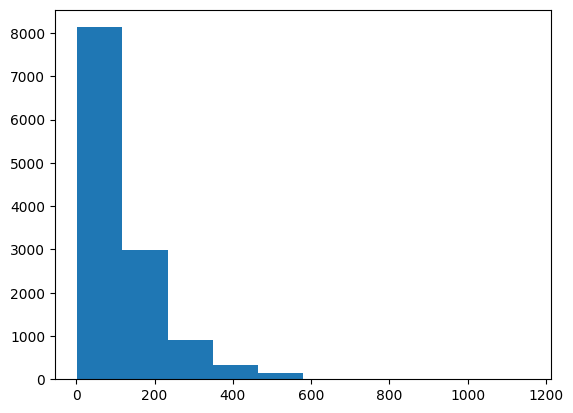

In [ ]:
# preprocess test set
test_clean_text, test_vocab = build_vocab(test['text'])
test_tokens = tokenize(test_clean_text, test_vocab)
test_padded_reviews = pad_sequence(test_tokens, seq_len=512)
plt.hist([len(review) for review in test_tokens])

## Train & Validation Loader

In [ ]:
# create custom datasets
train_dataset = TensorDataset(
    torch.from_numpy(padded_reviews).to(device),
    torch.from_numpy(np.array(train['label'])).float().to(device)
)

test_dataset = TensorDataset(
      torch.from_numpy(test_padded_reviews).to(device),
    torch.from_numpy(np.array(test['label'])).float().to(device)
)


In [ ]:
# create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = True
)

In [ ]:
train_data_features, train_labels = next(iter(train_dataloader))
print(f'Example Input Size: {train_data_features.size()}')
print(f'Example Input:\n {train_data_features}\n')

print(f'Example Output Size: {train_labels.size()}')
print(f'Example Output:\n {train_labels}')

Example Input Size: torch.Size([32, 512])
Example Input:
 tensor([[     0,      0,      0,  ...,   5337,    277,   1313],
        [     0,      0,      0,  ...,  69300, 132544,      1],
        [     0,      0,      0,  ...,   2904,   3305,    529],
        ...,
        [     0,      0,      0,  ...,     18,      4,    257],
        [     0,      0,      0,  ...,   1091,      4,    546],
        [     0,      0,      0,  ...,    145,     11,      2]],
       device='cuda:0')

Example Output Size: torch.Size([32])
Example Output:
 tensor([0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
       device='cuda:0')


# Model Instantiation and Training

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
    super().__init__()

    self.embedding_layer = nn.Embedding(input_dim, embedding_dim)
    self.rnn_layer = nn.RNN(embedding_dim, hidden_dim, num_layers=1)
    self.fc_layer = nn.Linear(hidden_dim, output_dim)

  def forward(self, sequence):

    # seq shape = seq_len, batch_size
    embedding = self.embedding_layer(sequence)
    output, hidden_state = self.rnn_layer(embedding)

    final_output =self.fc_layer(
        hidden_state[-1,:,:].squeeze(0)
    )

    return final_output


In [ ]:
input_dim = len(train_vocab) + 1
embedding_dim = 100
hidden_dim = 32
output_dim = 1

In [ ]:
rnn_model = RNN(input_dim, embedding_dim, hidden_dim, output_dim)
optimizer = optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()
rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [ ]:
def accuracy_metric(predictions, labels):
  """Returns 0-1 accuracy for the given set of predictions and labels"""
  rounded_predictions = torch.round(torch.sigmoid(predictions))
  success = (rounded_predictions == labels).float()
  return success.sum() / len(success)

In [ ]:
def training_loop(model, dataloader, optim, loss_func):
  loss = 0
  accuracy = 0
  model.train()

  for seq, sentiment in tqdm(dataloader):
    optim.zero_grad()
    predictions = model(seq.T).squeeze()
    loss_curr = loss_func(predictions,sentiment)
    accuracy_curr = accuracy_metric(predictions, sentiment)
    loss_curr.backward()
    optim.step()
    loss += loss_curr.item()
    accuracy += accuracy_curr.item()
  return loss/len(dataloader), accuracy/len(dataloader)

def validate(model, dataloader, loss_func):
  loss = 0
  accuracy = 0
  model.eval()
  with torch.no_grad():
    for seq, sentiment in tqdm(dataloader):
      predictions = model(seq.T).squeeze()
      loss_curr = loss_func(predictions,sentiment)
      accuracy_curr = accuracy_metric(predictions, sentiment)
      loss += loss_curr.item()
      accuracy += accuracy_curr.item()
  return loss/len(dataloader), accuracy/len(dataloader)

In [ ]:
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
  time_start = time.time()
  training_loss, training_accuracy = training_loop(
      rnn_model, train_dataloader, optimizer, loss_func)
  validation_loss, validation_accuracy = validate(
      rnn_model, test_dataloader, loss_func)

  time_end = time.time()
  time_delta = time_end - time_start

  if validation_loss < best_val_loss:
    best_val_loss = validation_loss
    torch.save(rnn_model.state_dict(), 'rnn_model.pt')

  print(f'epoch: {epoch+1} | time elapsed: {time_delta}s')
  print(f'training loss: {training_loss:.3f} | training accuracy: {training_accuracy*100:.2f}%')
  print(f'validation loss: {validation_loss:.3f} | validation accuracy: {validation_accuracy*100:.2f}%')

100%|██████████| 391/391 [00:00<00:00, 949.48it/s]


epoch: 1 | time elapsed: 10.308605194091797s
training loss: 0.605 | training accuracy: 66.18%
validation loss: 0.890 | validation accuracy: 49.59%


100%|██████████| 391/391 [00:00<00:00, 945.56it/s]


epoch: 2 | time elapsed: 9.342313051223755s
training loss: 0.480 | training accuracy: 78.54%
validation loss: 0.887 | validation accuracy: 50.50%


100%|██████████| 391/391 [00:00<00:00, 960.32it/s]


epoch: 3 | time elapsed: 10.396275043487549s
training loss: 0.407 | training accuracy: 82.98%
validation loss: 0.905 | validation accuracy: 50.67%


100%|██████████| 391/391 [00:00<00:00, 974.98it/s]


epoch: 4 | time elapsed: 9.543966054916382s
training loss: 0.349 | training accuracy: 85.85%
validation loss: 1.136 | validation accuracy: 50.14%


100%|██████████| 391/391 [00:00<00:00, 979.24it/s]


epoch: 5 | time elapsed: 9.522449731826782s
training loss: 0.281 | training accuracy: 89.31%
validation loss: 1.225 | validation accuracy: 49.73%


100%|██████████| 391/391 [00:00<00:00, 970.17it/s]


epoch: 6 | time elapsed: 9.536592483520508s
training loss: 0.233 | training accuracy: 91.51%
validation loss: 1.251 | validation accuracy: 49.38%


100%|██████████| 391/391 [00:00<00:00, 827.92it/s]


epoch: 7 | time elapsed: 9.423774480819702s
training loss: 0.245 | training accuracy: 90.52%
validation loss: 1.433 | validation accuracy: 50.52%


100%|██████████| 391/391 [00:00<00:00, 928.56it/s]


epoch: 8 | time elapsed: 9.56144118309021s
training loss: 0.168 | training accuracy: 94.34%
validation loss: 1.395 | validation accuracy: 50.31%


100%|██████████| 391/391 [00:00<00:00, 980.57it/s]


epoch: 9 | time elapsed: 9.584076881408691s
training loss: 0.150 | training accuracy: 94.93%
validation loss: 1.620 | validation accuracy: 50.38%


100%|██████████| 391/391 [00:00<00:00, 938.64it/s]

epoch: 10 | time elapsed: 9.564648151397705s
training loss: 0.118 | training accuracy: 96.25%
validation loss: 1.804 | validation accuracy: 50.66%
